<a href="https://colab.research.google.com/github/insu97/PAPER/blob/main/ImageNet_Classification_with_Deep_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[image.png](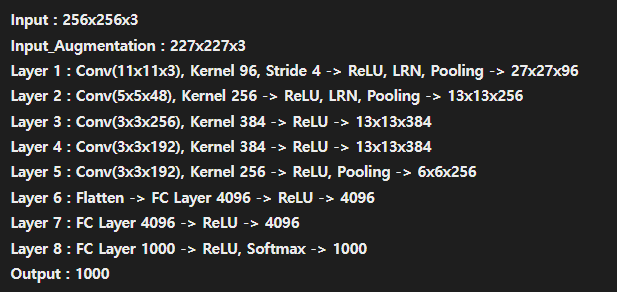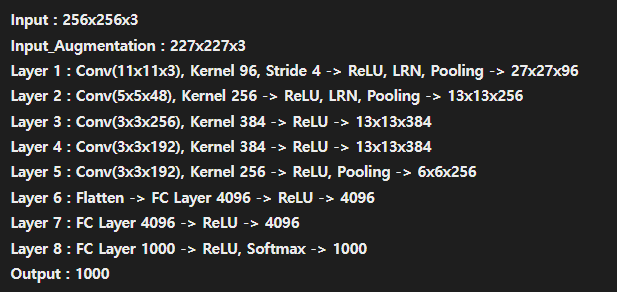)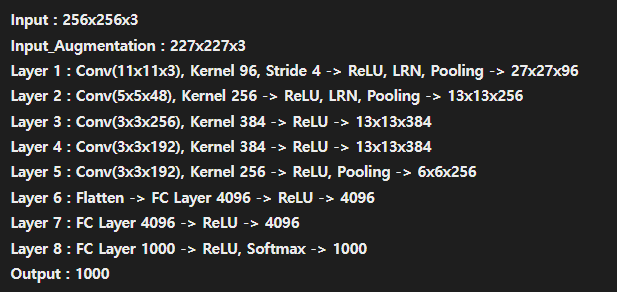

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd '/content/drive/MyDrive/CODE/'

/content/drive/MyDrive/CODE


In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
CFG = {
    'SEED' : 42
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227))
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = "images/", transform=transform)

In [ ]:
import numpy as np
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')
    return mean_r, mean_g, mean_b, std_r, std_g, std_b

mean_r, mean_g, mean_b, std_r, std_g, std_b = print_stats(dataset)

mean: (0.76957023, 0.7138707, 0.58354425)
std: (0.109059095, 0.087824136, 0.109626725)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)),
    transforms.Normalize((mean_r, mean_g, mean_b),(std_r, std_g, std_b)),
])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = "images/", transform=transform)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(dataset, test_size=0.2, random_state=CFG['SEED'])

In [ ]:
train, val = train_test_split(train, test_size=0.375, random_state=CFG['SEED'])

In [ ]:
len(train), len(val), len(test)

(25, 15, 10)

In [ ]:
df_train = DataLoader(train, batch_size=128, shuffle=True)
df_val = DataLoader(val, batch_size=128, shuffle=True)
df_test = DataLoader(test, batch_size=128, shuffle=True)

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11, stride=4),
            nn.ReLU(inplace=True), # inplace True means change input value as ReLU value
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2), # used same parameter in paper
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv3
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # conv4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # conv5
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            # fc1
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(inplace=True),
            # fc2
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        # initialize bias, weight
        def init_bias_weights(self):
            for layer in self.layers:
                if isinstance(layer, nn.Conv2d): # if layer is Conv
                    nn.init.normal_(layer.weight, mean=0, std=0.01) # Gaussian Distribution with (0, 0.01)
                    nn.init.constant_(layer.bias, 0) # default=0, 1 for 2, 4, 5, FC
            # conv2, 4, 5 bias for 1
            nn.init.constant_(self.layers[4].bias, 1)
            nn.init.constant_(self.layers[10].bias, 1)
            nn.init.constant_(self.layers[12].bias, 1)
            # FC bias for 1
            nn.init.constant_(self.classifier[1].bias, 1)
            nn.init.constant_(self.classifier[4].bias, 1)
            nn.init.constant_(self.classifier[6].bias, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = AlexNet(num_classes=2)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0005
    for i, data in enumerate(df_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in df_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10 test images: 70.00%


In [ ]:
correct_top1 = 0
correct_top5 = 0
total = 0

with torch.no_grad():
    for data in df_train:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)

        # Top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 accuracy
        _, top5_pred = outputs.topk(2, dim=1)
        top5_pred = top5_pred.t()  # Transpose to get [5, batch_size]
        correct_top5 += top5_pred.eq(labels.view(1, -1).expand_as(top5_pred)).sum().item()

        total += labels.size(0)

top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total

print(f'Top-1 Accuracy: {top1_accuracy:.2f}%')
print(f'Top-5 Accuracy: {top5_accuracy:.2f}%')

Top-1 Accuracy: 48.00%
Top-5 Accuracy: 100.00%


In [ ]:
from torchsummary import summary as summary_

summary_(net, (3, 227, 227))
# summary_: (model, input_size, batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,